# **任务5 卷积分类 Convolutional Neural Network (CNN) - Classification**

在任务二中引入了第一种真正定义为深度学习的任务，使用的是线性层（全连接层），该结构的特点是将所有数据构建线性映射，这种方式往往会过度连接一些没有必要强调的参数关联。

___

## 1. **新的层结构**

### 1.1 **torch二维卷积层**
卷积神经网络中是更注重空间信息的一种处理方式，具体实现过程不做过多阐述，仅从代码层面记录用法。

### **使用方法**

它同样来自于 `torch` 的 `nn` 子类中，`nn.Linearnn.Conv2d(input_dim, output_dim, kernel_size=ks, padding=pd)`
其中的每个参数的效果逐个展示

In [150]:
import torch
import torch.nn as nn

batch_size = 4
input_tensor = torch.rand((batch_size, 1, 32, 32))

conv0 = nn.Conv2d(1, 3, kernel_size=3, padding=1, stride=1)
conv1 = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=1)
conv2 = nn.Conv2d(1, 1, kernel_size=5, padding=1, stride=1)
conv3 = nn.Conv2d(1, 1, kernel_size=3, padding=0, stride=1)
conv4 = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
output_tensor0 = conv0(input_tensor)
output_tensor1 = conv1(input_tensor)
output_tensor2 = conv2(input_tensor)
output_tensor3 = conv3(input_tensor)
output_tensor4 = conv4(input_tensor)

print('输入形状：', output_tensor0.shape)
print('input_dim=1, output_dim=3, kernel_size=3, padding=1, stride=1 输出形状：', output_tensor0.shape)
print('input_dim=1, output_dim=1, kernel_size=3, padding=1, stride=1 输出形状：', output_tensor1.shape)
print('input_dim=1, output_dim=1, kernel_size=5, padding=1, stride=1 输出形状：', output_tensor2.shape)
print('input_dim=1, output_dim=1, kernel_size=3, padding=0, stride=1 输出形状：', output_tensor3.shape)
print('input_dim=1, output_dim=1, kernel_size=3, padding=1, stride=2 输出形状：', output_tensor4.shape)

输入形状： torch.Size([4, 3, 32, 32])
input_dim=1, output_dim=3, kernel_size=3, padding=1, stride=1 输出形状： torch.Size([4, 3, 32, 32])
input_dim=1, output_dim=1, kernel_size=3, padding=1, stride=1 输出形状： torch.Size([4, 1, 32, 32])
input_dim=1, output_dim=1, kernel_size=5, padding=1, stride=1 输出形状： torch.Size([4, 1, 30, 30])
input_dim=1, output_dim=1, kernel_size=3, padding=0, stride=1 输出形状： torch.Size([4, 1, 30, 30])
input_dim=1, output_dim=1, kernel_size=3, padding=1, stride=2 输出形状： torch.Size([4, 1, 16, 16])


$$
H_{out} = \left\lfloor \frac{H_{in} + 2p - k}{s} + 1 \right\rfloor
$$
$$
W_{out} = \left\lfloor \frac{W_{in} + 2p - k}{s} + 1 \right\rfloor
$$

### 符号说明
- $H_{in}/W_{in}$：输入特征图的高/宽
- $H_{out}/W_{out}$：输出特征图的高/宽
- $k$：方形卷积核边长（$k_H=k_W=k$）
- $p$：对称填充尺寸（$p_H=p_W=p$）
- $s$：卷积统一步长（$s_H=s_W=s$）
- $\lfloor \cdot \rfloor$：向下取整
具体作用说明，特征张量维度为 **[batch_size, channel, height, width]**：
- input_dim, output_dim：用于限定输入输出维度，与线性层作用相似，作用于 **channel** 维度。
- kernel_size：卷积核，主要影响的是模型的感受野，也就是同时关注的图像特征的面积。本质上是一个滑动窗口，不能超过图像宽高+padding的大小。
- padding：填充，用于调整特征图大小，在左右上下分别填充padding个像素点。
- stride：步长。滑动窗口一次滑动多少距离。

宽度和高度的维度变化满足以上公式，实际使用可以断点测试以让模型维度匹配

实际任务中卷积核取3，5，7，填充分别取1，3，5比较常用，因为不会改变特征图的大小，便于推导后续层的衔接。

### 1.2 **torch池化层**
用于压缩和精简特征图的宽高，是一种固定的运算逻辑，不引入参数量。

常见的分为均值池化和最大池化：
- 均值池化 `nn.MaxPool2d(kernel_size=ks, stride=st)`：将滑动窗口内的特征值取均值，将计算结果作为新的特征值，比较平滑
- 最大池化 `nn.AvgPool2d(kernel_size=ks, stride=st)`：将滑动窗口内的特征值取最大值，将计算结果作为新的特征值

两种池化方式仅在处理逻辑上有差异，相同参属下对特征维度的影响相同，以下示例中仅以最大池化为例

### **使用方法**

In [151]:
input_tensor = torch.rand((batch_size, 1, 32, 32))

pool0 = nn.MaxPool2d(kernel_size=1, stride=1)
pool1 = nn.MaxPool2d((2, 1), stride=1)
pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
pool3 = nn.MaxPool2d(kernel_size=2, stride=2)      # 最常用

output0 = pool0(input_tensor)
output1 = pool1(input_tensor)
output2 = pool2(input_tensor)
output3 = pool3(input_tensor)
print('输入形状：', input_tensor.shape)
print('size=(1, 1), stride=1 输出形状：', output0.shape)
print('size=(2, 1), stride=1 输出形状：', output1.shape)
print('size=(2, 2), stride=1 输出形状：', output2.shape)
print('size=(2, 2), stride=2 输出形状：', output3.shape)

输入形状： torch.Size([4, 1, 32, 32])
size=(1, 1), stride=1 输出形状： torch.Size([4, 1, 32, 32])
size=(2, 1), stride=1 输出形状： torch.Size([4, 1, 31, 32])
size=(2, 2), stride=1 输出形状： torch.Size([4, 1, 31, 31])
size=(2, 2), stride=2 输出形状： torch.Size([4, 1, 16, 16])


实际任务中核大小等于步长比较常用，特征图大小会变为 $1/步长$ 倍，便于推导后续层的衔接。

### 1.3 **torch展平层**
用于压缩和精简特征图的宽高，是一种固定的逻辑，不引入参数量。代码`nn.Flatten()`.

In [152]:
tensor = torch.rand((batch_size, 3, 5, 5))
flatten = nn.Flatten()

output = flatten(tensor)

print('输入形状：', tensor.shape)
print('展平输出形状：', output.shape)

输入形状： torch.Size([4, 3, 5, 5])
展平输出形状： torch.Size([4, 75])


将 **通道和宽高** 维度的空间特征去掉，展平成线性层常用的特征值。

## 2. **定义模型**


In [153]:
class CNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(CNN, self).__init__()
        self.img_encoder = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hidden_dim, output_dim, kernel_size=3, padding=1),
        )
        self.flatten = nn.Flatten()

        self.output_layer = nn.Linear(128, 2)

    def forward(self, x):
        x = self.img_encoder(x)
        x = self.flatten(x)
        x = self.output_layer(x)
        return x

这里使用了 `nn.Sequential()` 方法用于打包一些有固定流程的前向传播层数，让它们逐个执行。

卷积神经网络同样可以使用激活函数增加非线性。

输出层 `output_layer` 的输入维度通常需要冗长的推算，实际使用可以先断点测试。

## 3. **数据生成**

圆形和方形图像的二分类

输入数据形状: torch.Size([512, 3, 64, 64])
输入批次数量: 4 	批次形状: torch.Size([128, 3, 64, 64])
标签数据形状: torch.Size([512])
输入批次数量: 4 	批次形状: torch.Size([128])


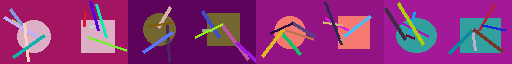

In [154]:
import random
from PIL import Image, ImageDraw
import torchvision.transforms as transforms

def get_data(data_size, img_size):
    train_images = []
    # 用于存储对应类别标签的列表
    train_labels = []
    show_img_list = []
    for x in range(data_size // 2):
        b_col = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        loc_0, lod_1 = (random.randint(10, 20), random.randint(10, 20)), (random.randint(img_size - 20, img_size - 10), random.randint(img_size - 20, img_size - 10))
        file_col = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

        image0 = Image.new('RGB', (img_size, img_size), b_col)
        image1 = Image.new('RGB', (img_size, img_size), b_col)

        draw0 = ImageDraw.Draw(image0)
        draw0.ellipse((loc_0, lod_1), fill=file_col)
        for _ in range(5):
            draw0.line([(random.randint(0, img_size), random.randint(0, img_size)), (random.randint(20, img_size - 20), random.randint(20, img_size - 20))], fill=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), width=3)

        draw1 = ImageDraw.Draw(image1)
        draw1.rectangle((loc_0, lod_1), fill=file_col)
        for _ in range(5):
            draw1.line([(random.randint(0, img_size), random.randint(0, img_size)), (random.randint(20, img_size - 20), random.randint(20, img_size - 20))], fill=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), width=3)


        if len(show_img_list) < 8:
            show_img_list.append(image0)
            show_img_list.append(image1)

        # 组合变换操作
        transform = transforms.Compose([
            transforms.ToTensor(),
            # 归一化操作，使用上面定义的均值和标准差
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            # 随机水平翻转，设置概率为0.5，意味着有50%的概率进行水平翻转
            transforms.RandomHorizontalFlip(p=0.5),
            # 随机垂直翻转，同样设置概率为0.5
            transforms.RandomVerticalFlip(p=0.5),
        ])
        image0 = transform(image0)
        train_images.append(image0)
        train_labels.append(0)

        image1= transform(image1)
        train_images.append(image1)
        train_labels.append(1)

    # 转换为张量
    train_images, train_labels = torch.stack(train_images), torch.tensor(train_labels)
    return train_images, train_labels, show_img_list

# 划分批次
def split_batch(data, batch_size):
    # 核心操作：沿第一个维度（dim=0）分割，保留后续所有维度
    split_tensors = torch.split(data, batch_size, dim=0)
    # 转为列表返回（torch.split返回tuple，列表更易操作）
    return list(split_tensors)

# 训练数据
img_size = 64
batch_size = 128
train_x, train_y, show_img_list = get_data(512, img_size)
train_x_batch = split_batch(train_x, batch_size)
train_y_batch = split_batch(train_y, batch_size)
# 验证数据
val_x, val_y, _ = get_data(128, img_size)
# 测试数据
test_x, test_y, _ = get_data(6, img_size)
print('输入数据形状:', train_x.shape)
print('输入批次数量:', len(train_x_batch), '\t批次形状:', train_x_batch[0].shape)
print('标签数据形状:', train_y.shape)
print('输入批次数量:', len(train_y_batch), '\t批次形状:', train_y_batch[0].shape)

m = 0
combined = Image.new('RGB', (img_size*len(show_img_list), img_size))
for img in show_img_list:
    combined.paste(img, (m, 0))    # 把a贴到画布左侧
    m += img_size
combined

图像的数据处理存在些许差异，图像本身不是数组，需要手动转换 `transforms.ToTensor()`。

图像的数值范围是0到255，这个跨度很大，容易影响数据的拟合，所以需要归一化方法来压缩这个区间 `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`。

这里还用了些许数据增强方法来扩展数据集，有助于模型泛化 随机翻转：`transforms.RandomHorizontalFlip(p=0.5)` 和 `transforms.RandomVerticalFlip(p=0.5)`

```
transform = transforms.Compose([
            transforms.ToTensor(),
            # 归一化操作，使用上面定义的均值和标准差
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            # 随机水平翻转，设置概率为0.5，意味着有50%的概率进行水平翻转
            transforms.RandomHorizontalFlip(p=0.5),
            # 随机垂直翻转，同样设置概率为0.5
            transforms.RandomVerticalFlip(p=0.5),
        ])
```

## 4. 模型训练

### 4.1 实例化模型、损失函数、优化器

本次任务虽然是二分类，但采用的是多分类的模式，及同样输出两个概率得分，所以使用交叉熵损失 `nn.CrossEntropyLoss()`。

由于图像的计算比较复杂，所以通常需要使用显卡并行计算，使用 `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")` 来判断显卡的cuda设备是否可用，然后使用 `to` 方法将数据和模型全都转到cuda上计算.

数据和模型的设备必须同步，不然会报错。

In [155]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(3, 2, 32).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

### 4.2 **迭代训练**

In [156]:
epochs = 50
for epoch in range(epochs):
    loss = None
    for i in range(len(train_x_batch)):
        x = train_x_batch[i].to(device)
        y = train_y_batch[i].to(device)
        model.train()
        # 前向传播，得到预测值
        output = model(x)
        # 计算损失
        loss = criterion(output, y)
        # 梯度清零，因为在每次反向传播前都要清除之前累积的梯度
        optimizer.zero_grad()
        # 反向传播，计算梯度
        loss.backward()
        # 更新权重和偏置
        optimizer.step()

    val_x = val_x.to(device)
    val_y = val_y.to(device)
    model.eval()
    output = model(val_x)
    val_loss = criterion(output, val_y).item()

    # 更改验证逻辑为适合分类任务的准确率和召回率
    if (epoch + 1) % 10 == 0:
        print(f'[epoch {epoch+1}]loss:', loss.item())
        print(f'\t val loss:', val_loss)


[epoch 10]loss: 0.5503224730491638
	 val loss: 0.5038346648216248
[epoch 20]loss: 0.31864652037620544
	 val loss: 0.33735543489456177
[epoch 30]loss: 0.1473662555217743
	 val loss: 0.25354164838790894
[epoch 40]loss: 0.05005957558751106
	 val loss: 0.2573327422142029
[epoch 50]loss: 0.01585533283650875
	 val loss: 0.2855958342552185


### 4.3 **测试模型**

使用 `model.eval()` 将模型改为测试模式，避免自动的梯度计算增加额外的计算量。

使用 `torch.argmax()` 将概率得分向量转换为类别索引。

In [157]:
model.eval()
test_x = test_x.to(device)
output = model(test_x)

for i in range(len(test_x)):
    print('输入数据:', test_x[i].shape)
    print('目标结果:', test_y[i].item())
    print('预测结果:', torch.argmax(output, dim=1)[i].item())

输入数据: torch.Size([3, 64, 64])
目标结果: 0
预测结果: 0
输入数据: torch.Size([3, 64, 64])
目标结果: 1
预测结果: 1
输入数据: torch.Size([3, 64, 64])
目标结果: 0
预测结果: 0
输入数据: torch.Size([3, 64, 64])
目标结果: 1
预测结果: 1
输入数据: torch.Size([3, 64, 64])
目标结果: 0
预测结果: 0
输入数据: torch.Size([3, 64, 64])
目标结果: 1
预测结果: 0


## 5. **总结**

这是第五个关于 `torch` 框架的任务，初步认识到了神经网络的第一个变体——卷积，更关注空间信息，除了二维卷积还有一维和三维的卷积，分别适用于不同的任务，在后续会使用具体的项目进行记录。